In [97]:
#Importing required Libraries
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
%matplotlib inline
from bs4 import BeautifulSoup
import seaborn as sns
pd.set_option("display.max_columns", None)

# DATA GATHERING

In [98]:
#Twitter archive data
tw_archive_df = pd.read_csv('twitter-archive-enhanced.csv')
#Image predictions data
img_pre_df = pd.read_csv("image_predictions.tsv", sep = "\t")

In [99]:
# extract data from Twitter API data (tweet_json.txt), convert to data frame with tweets id , retweet_count and favorite_count
tweets_list = []
with open('tweet-json.txt' , 'r') as file:
    for lines in file:
        tweet = json.loads(lines)
        tweet_id = tweet['id']
        retweet_count = tweet['retweet_count']
        fav_count = tweet['favorite_count']
        tweets_list.append({'tweet_id':tweet_id,
                       'retweet_count': retweet_count,
                       'favorite_count': fav_count})
tweets_list
tweets_df = pd.DataFrame(tweets_list)

In [100]:
def ExplorationDataset(data_set):
    expo = data_set
    """shape of dataset"""
    print('[The Concise Summary of The Dataset]\n▸Your Dataset has {0} Rows and {1} Columns'
          .format(expo.shape[0] ,expo.shape[1]))
    """check the number of duplicated row"""
    print('▸Number of Duplicates Rows in Dataset = ', sum(expo.duplicated()))
    """check columns with missing values"""
    
    sum_of_null_values = expo.isnull().sum().sum()
    if sum_of_null_values > 0:
        print("▸Columns With Missing Values")
        for columns in expo:
            if expo[columns].isnull().any():
                print('[{0}] has: {1} null values , Percentage = {2:.2f}% '
                .format(columns, expo[columns].isnull().sum(), 
                      100 * expo[columns].isnull().sum() / len(expo[columns])))
    else:
        print("▸Dataset hasn't Misssing Values")
    print("----------------------------------------------------------------")
    """check columns of datsset"""
    for columns in expo:
        numberofunique = expo[columns].nunique()
        """check column datatype , unique values and their number and values in column count"""
        print("▸Column's Name : {0}\n▸Column's Datatype : {1}\n▸Number of Unique Values : {2}" 
              .format(columns,expo.dtypes[columns], numberofunique) )
        if numberofunique <= 10 :
             print("▸Unique Values :\n" , expo[columns].unique()[:10])
        print("▸Column's Values Count : \n{0}\n -------------------------------" .format(expo[columns].value_counts()))
        print("----------------------------------------------------------------")
     

# DATA ASSESSMENT AND CLEANING

In [101]:
#display samples of Twitter archive data
tw_archive_df.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2344,666071193221509120,NaN,NaN,2015-11-16 01:52:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a northern speckled Rhododendron....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666071193...,9,10,None,None,None,None,None
1392,700062718104104960,NaN,NaN,2016-02-17 21:02:13 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Eazy-E. He's colorful af. Must be rare...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/700062718...,6,10,Eazy,None,None,None,None
2278,667435689202614272,NaN,NaN,2015-11-19 20:14:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Ermergerd 12/10 https://t.co/PQni2sjPsm,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667435689...,12,10,None,None,None,None,None
1788,677557565589463040,NaN,NaN,2015-12-17 18:34:46 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Reckless pupper here. Not even looking at road...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/677557565...,10,10,None,None,None,pupper,None
1630,684538444857667585,6.844811e+17,4.196984e+09,2016-01-06 00:54:18 +0000,"<a href=""http://twitter.com/download/iphone"" r...","After watching this video, we've determined th...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/684538444...,12,10,None,None,None,None,None
214,851464819735769094,NaN,NaN,2017-04-10 16:00:07 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Iggy. He was a rescue dog killed in th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/851464819...,14,10,Iggy,None,None,None,None
1040,744223424764059648,NaN,NaN,2016-06-18 17:41:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is actually a pupper and I'd pet it so we...,NaN,NaN,NaN,https://twitter.com/strange_animals/status/672...,12,10,actually,None,None,pupper,None
1301,707629649552134146,NaN,NaN,2016-03-09 18:10:30 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",We usually don't rate marshmallows but this on...,NaN,NaN,NaN,https://vine.co/v/iHhBOTl5p9z,10,10,None,None,None,None,None
462,817502432452313088,NaN,NaN,2017-01-06 22:45:43 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Herschel. He's slightly bi...,6.924173e+17,4.196984e+09,2016-01-27 18:42:06 +0000,https://twitter.com/dog_rates/status/692417313...,7,10,Herschel,None,None,pupper,None
555,803692223237865472,NaN,NaN,2016-11-29 20:08:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: I present to you... Dog Jesus. ...,6.914169e+17,4.196984e+09,2016-01-25 00:26:41 +0000,https://twitter.com/dog_rates/status/691416866...,13,10,None,None,None,None,None


In [102]:
#Assessing Twitter archive data
ExplorationDataset(tw_archive_df)

[The Concise Summary of The Dataset]
▸Your Dataset has 2356 Rows and 17 Columns
▸Number of Duplicates Rows in Dataset =  0
▸Columns With Missing Values
[in_reply_to_status_id] has: 2278 null values , Percentage = 96.69% 
[in_reply_to_user_id] has: 2278 null values , Percentage = 96.69% 
[retweeted_status_id] has: 2175 null values , Percentage = 92.32% 
[retweeted_status_user_id] has: 2175 null values , Percentage = 92.32% 
[retweeted_status_timestamp] has: 2175 null values , Percentage = 92.32% 
[expanded_urls] has: 59 null values , Percentage = 2.50% 
----------------------------------------------------------------
▸Column's Name : tweet_id
▸Column's Datatype : int64
▸Number of Unique Values : 2356
▸Column's Values Count : 
700151421916807169    1
674764817387900928    1
794926597468000259    1
701570477911896070    1
715220193576927233    1
                     ..
674742531037511680    1
756651752796094464    1
743545585370791937    1
770655142660169732    1
749075273010798592    1
N

#### Assessing Twitter archive data results
1. in_reply_to_status_id, in_reply_to_user_id, retweeted_status_user_id and retweeted_status_timestamp have high percentage of missing values so we will drop them 
2. tweet_id is stored as int , it should stored as object
3. timestamp is stored as object , it should stored as datetime
4. extract source as text and stored it as catogray
6. convert Nona and a values in name to nan
7. extract dogs stage from text, then drop doggo, floofer, pupper and puppo columns
8. the fact that the rating numerators are greater than the denominators does not need to be cleaned. This unique rating system is a big part of the popularity of WeRateDogs.



### Code

In [103]:
def CleanArchiveData(data_set):
    """Code of cleaning Twitter archive data"""
    # Make copy of original data
    test = data_set.copy()
    #Extract text from source column
    test['source'] = [BeautifulSoup(X).getText() for X in test['source']]
    #change tweet_id datatype to object
    test['tweet_id'] = test['tweet_id'].astype("str")
    #change timestamp datatype to pandas datetime and split to data and time columns
    test['timestamp'] = pd.to_datetime(test['timestamp'])
    #Remove the time zone from the 'timestamp' column
    test['timestamp'] = test['timestamp'].dt.tz_localize(None)
    #replace 'None' and 'a' to nan
    test['name'] = test['name'].replace({'None': np.nan , 'a' : np.nan})
    test['name'] = test['name'].str.lower()
    #Extract dogs stage from text
    test['dogs_stage'] = test['text'].str.extract('(puppo|pupper|floofer|doggo|Puppo|Pupper|Floofer|Doggo)')
    test['dogs_stage'] = test['dogs_stage'].str.lower()
    #change 'source' and 'dogs_stage' to category
    test[['source', 'dogs_stage']] = test[['source', 'dogs_stage']].astype('category')
    #drop columns with too many missing values and not useful in analysis 
    test = test.drop(columns=['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id',
                                            'retweeted_status_user_id','retweeted_status_timestamp', 'expanded_urls',
                                             'doggo', 'floofer', 'pupper', 'puppo'] , axis=1)
    return test 
clean_archive = CleanArchiveData(tw_archive_df)

### Test

In [104]:
clean_archive.head()

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,dogs_stage
0,892420643555336193,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,13,10,phineas,NaN
1,892177421306343426,2017-08-01 00:17:27,Twitter for iPhone,This is Tilly. She's just checking pup on you....,13,10,tilly,NaN
2,891815181378084864,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,12,10,archie,NaN
3,891689557279858688,2017-07-30 15:58:51,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,13,10,darla,NaN
4,891327558926688256,2017-07-29 16:00:24,Twitter for iPhone,This is Franklin. He would like you to stop ca...,12,10,franklin,NaN


In [105]:
clean_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            2356 non-null   object        
 1   timestamp           2356 non-null   datetime64[ns]
 2   source              2356 non-null   category      
 3   text                2356 non-null   object        
 4   rating_numerator    2356 non-null   int64         
 5   rating_denominator  2356 non-null   int64         
 6   name                1556 non-null   object        
 7   dogs_stage          418 non-null    category      
dtypes: category(2), datetime64[ns](1), int64(2), object(3)
memory usage: 115.6+ KB


In [106]:
#display samples of Image predictions data
img_pre_df.sample(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1212,743210557239623680,https://pbs.twimg.com/media/ClBqDuDWkAALK2e.jpg,1,golden_retriever,0.930705,True,Chesapeake_Bay_retriever,0.025934,True,Labrador_retriever,0.007535,True
170,668992363537309700,https://pbs.twimg.com/media/CUi9ARGWUAEyWqo.jpg,1,lynx,0.287506,False,tabby,0.206048,False,koala,0.081419,False
1452,776813020089548800,https://pbs.twimg.com/media/CsfLUDbXEAAu0VF.jpg,1,toy_poodle,0.516610,True,miniature_poodle,0.255033,True,standard_poodle,0.168989,True
41,666701168228331520,https://pbs.twimg.com/media/CUCZLHlUAAAeAig.jpg,1,Labrador_retriever,0.887707,True,Chihuahua,0.029307,True,French_bulldog,0.020756,True
1019,710140971284037632,https://pbs.twimg.com/media/Cdrtcr-W4AAqi5H.jpg,1,Pekinese,0.953170,True,papillon,0.019517,True,Japanese_spaniel,0.005821,True
1314,754856583969079297,https://pbs.twimg.com/media/CnnKCKNWgAAcOB8.jpg,2,golden_retriever,0.872385,True,Labrador_retriever,0.099963,True,cocker_spaniel,0.006051,True
440,674447403907457024,https://pbs.twimg.com/media/CVweVUfW4AACPwI.jpg,1,Brabancon_griffon,0.409909,True,malinois,0.244649,True,bull_mastiff,0.074819,True
478,675334060156301312,https://pbs.twimg.com/media/CV9EvZNUwAAgLCK.jpg,2,Pembroke,0.773135,True,Cardigan,0.116810,True,chow,0.039036,True
1405,769940425801170949,https://pbs.twimg.com/media/Cq9guJ5WgAADfpF.jpg,1,miniature_pinscher,0.796313,True,Chihuahua,0.155413,True,Staffordshire_bullterrier,0.030943,True
493,675707330206547968,https://pbs.twimg.com/media/CWCYOqWUAAARmGr.jpg,1,bath_towel,0.721933,False,Staffordshire_bullterrier,0.059344,True,bagel,0.035702,False


In [107]:
#Assessing Image predictions data
ExplorationDataset(img_pre_df)

[The Concise Summary of The Dataset]
▸Your Dataset has 2075 Rows and 12 Columns
▸Number of Duplicates Rows in Dataset =  0
▸Dataset hasn't Misssing Values
----------------------------------------------------------------
▸Column's Name : tweet_id
▸Column's Datatype : int64
▸Number of Unique Values : 2075
▸Column's Values Count : 
700151421916807169    1
740373189193256964    1
836989968035819520    1
816336735214911488    1
688828561667567616    1
                     ..
675354435921575936    1
759923798737051648    1
705475953783398401    1
693231807727280129    1
817056546584727552    1
Name: tweet_id, Length: 2075, dtype: int64
 -------------------------------
----------------------------------------------------------------
▸Column's Name : jpg_url
▸Column's Datatype : object
▸Number of Unique Values : 2009
▸Column's Values Count : 
https://pbs.twimg.com/media/CmoPdmHW8AAi8BI.jpg                                            2
https://pbs.twimg.com/media/CiibOMzUYAA9Mxz.jpg             

In [108]:
#describe method for numircal values
img_pre_df.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


#### Assessing Image predictions data results
1. tweet_id is stored as int , it should stored as object
2. img_num is stored as int , it should stored as category
3. p1_cof always has the highest confidence percentage than p2_cof and p3_cof
4. creat two columns 'confidence' and 'dog_breed' with confidence percentage refer to dog breed


## Code

In [109]:
def CleanImgPreData(data_set):
 
    """Code of cleaning Image predictions data"""
    # Make copy of original data
    test1 = data_set.copy()
    #change tweet_id datatype to object
    test1['tweet_id'] = test1['tweet_id'].astype("str")
    #creat'confidence' and 'dog_breed' with confidence percentage refer to dog breed
    breed = []
    confidence= []
    for index, rows in test1.iterrows():
        if rows['p1_dog'] == True :
            breed.append(rows['p1'])
            confidence.append(int(rows['p1_conf']*100))
        else :
            if rows['p2_dog'] == True:
                breed.append(rows['p2'])
                confidence.append(int(rows['p2_conf']*100))
            else :
                if rows['p3_dog'] == True:
                    breed.append(rows['p3'])
                    confidence.append(int(rows['p3_conf']*100))
                else :
                    breed.append(np.nan)
                    confidence.append(np.nan)
    test1['confidence %'] = confidence
    test1['confidence %'] = test1['confidence %'].astype('Int64')
    test1['dog_breed'] = breed
    test1['dog_breed'] = test1['dog_breed'].str.lower()
    #drop columns with too many missing values and not useful in analysis 
    test1 = test1.drop(columns=['p1','p2','p3','p1_conf','p2_conf','p3_conf','p1_dog','p2_dog','p3_dog'] , axis=1)
    return test1
cleaned_imgpre = CleanImgPreData(img_pre_df)
    

### Test

In [110]:
cleaned_imgpre.head()

,tweet_id,jpg_url,img_num,confidence %,dog_breed
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,46,welsh_springer_spaniel
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,50,redbone
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,59,german_shepherd
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,40,rhodesian_ridgeback
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,56,miniature_pinscher


In [111]:
cleaned_imgpre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   tweet_id      2075 non-null   object
 1   jpg_url       2075 non-null   object
 2   img_num       2075 non-null   int64 
 3   confidence %  1751 non-null   Int64 
 4   dog_breed     1751 non-null   object
dtypes: Int64(1), int64(1), object(3)
memory usage: 83.2+ KB


In [112]:
#descriptive statistics for dataset
cleaned_imgpre.describe()

,img_num,confidence %
count,2075.000000,1751.000000
mean,1.203855,54.390634
std,0.561875,29.862473
min,1.000000,0.000000
25%,1.000000,30.000000
50%,1.000000,54.000000
75%,1.000000,82.000000
max,4.000000,99.000000


In [113]:
#drop rows with missing values
#cleaned_imgpre = cleaned_imgpre.dropna()
#check changes
#cleaned_imgpre.info()

In [114]:
#display samples of Twitter API data
tweets_df.sample(10)

,tweet_id,retweet_count,favorite_count
1440,696754882863349760,396,1615
234,847606175596138505,3774,20208
1057,741743634094141440,3144,8945
446,819015331746349057,21794,0
806,771908950375665664,2181,7298
2187,668967877119254528,25,161
145,863471782782697472,2687,0
2069,671115716440031232,842,1436
1336,705066031337840642,683,2378
1116,732005617171337216,6154,16324


In [115]:
#Assessing Twitter API data
ExplorationDataset(tweets_df)

[The Concise Summary of The Dataset]
▸Your Dataset has 2354 Rows and 3 Columns
▸Number of Duplicates Rows in Dataset =  0
▸Dataset hasn't Misssing Values
----------------------------------------------------------------
▸Column's Name : tweet_id
▸Column's Datatype : int64
▸Number of Unique Values : 2354
▸Column's Values Count : 
700151421916807169    1
713175907180089344    1
754482103782404096    1
699446877801091073    1
794926597468000259    1
                     ..
674742531037511680    1
756651752796094464    1
743545585370791937    1
770655142660169732    1
749075273010798592    1
Name: tweet_id, Length: 2354, dtype: int64
 -------------------------------
----------------------------------------------------------------
▸Column's Name : retweet_count
▸Column's Datatype : int64
▸Number of Unique Values : 1724
▸Column's Values Count : 
3652    5
1972    5
83      5
819     4
115     4
       ..
1526    1
230     1
1522    1
5616    1
7       1
Name: retweet_count, Length: 1724, dtyp

In [116]:
tweets_df.describe()

,tweet_id,retweet_count,favorite_count
count,2.354000e+03,2354.000000,2354.000000
mean,7.426978e+17,3164.797366,8080.968564
std,6.852812e+16,5284.770364,11814.771334
min,6.660209e+17,0.000000,0.000000
25%,6.783975e+17,624.500000,1415.000000
50%,7.194596e+17,1473.500000,3603.500000
75%,7.993058e+17,3652.000000,10122.250000
max,8.924206e+17,79515.000000,132810.000000


#### Assessing Twitter API data data results 
1. tweet_id is stored as int , it should stored as object
2. favorite_count has zero values

## Code

In [117]:
def CleantweetData(data_set):
    test2 = data_set.copy()
    #change tweet_id datatype to object
    test2['tweet_id'] = test2['tweet_id'].astype("str")
    
    return test2
clean_tweet = CleantweetData(tweets_df)

## Test 

In [118]:
clean_tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet_id        2354 non-null   object
 1   retweet_count   2354 non-null   int64 
 2   favorite_count  2354 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 55.3+ KB


### Code


In [236]:
#merge 3 datasets to twitter_archive_master
master = pd.merge(clean_archive, clean_tweet,  on='tweet_id')
master = pd.merge(master, cleaned_imgpre , on = 'tweet_id')
master.to_csv('twitter_archive_master.csv')
master.head()


,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,dogs_stage,retweet_count,favorite_count,jpg_url,img_num,confidence %,dog_breed
0,892420643555336193,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,13,10,phineas,NaN,8853,39467,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,<NA>,NaN
1,892177421306343426,2017-08-01 00:17:27,Twitter for iPhone,This is Tilly. She's just checking pup on you....,13,10,tilly,NaN,6514,33819,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,32,chihuahua
2,891815181378084864,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,12,10,archie,NaN,4328,25461,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,71,chihuahua
3,891689557279858688,2017-07-30 15:58:51,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,13,10,darla,NaN,8964,42908,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,16,labrador_retriever
4,891327558926688256,2017-07-29 16:00:24,Twitter for iPhone,This is Franklin. He would like you to stop ca...,12,10,franklin,NaN,9774,41048,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,55,basset


### Test

In [120]:
#check changes
master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2073 entries, 0 to 2072
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            2073 non-null   object        
 1   timestamp           2073 non-null   datetime64[ns]
 2   source              2073 non-null   category      
 3   text                2073 non-null   object        
 4   rating_numerator    2073 non-null   int64         
 5   rating_denominator  2073 non-null   int64         
 6   name                1441 non-null   object        
 7   dogs_stage          353 non-null    category      
 8   retweet_count       2073 non-null   int64         
 9   favorite_count      2073 non-null   int64         
 10  jpg_url             2073 non-null   object        
 11  img_num             2073 non-null   int64         
 12  confidence %        1750 non-null   Int64         
 13  dog_breed           1750 non-null   object      

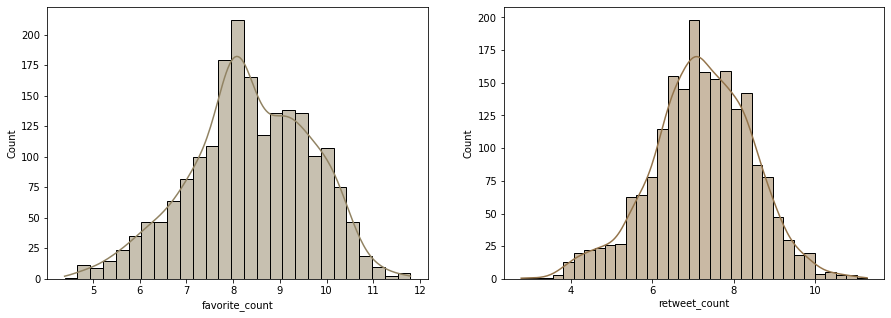

In [300]:
#Favorite and Retweet count (Normalized)
fig, axes = plt.subplots(1,2,figsize=(15,5))
sns.histplot(master.favorite_count.apply(np.log),kde=True,ax=axes[0],color='#918363');
sns.histplot(master.retweet_count.apply(np.log),kde=True,ax=axes[1],color='#94744B');

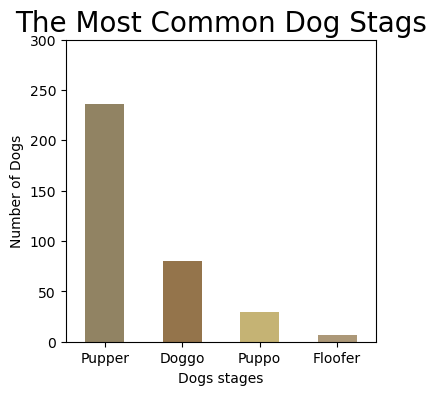

In [281]:
colors = ['#918363', '#94744B', '#C5B374', '#AC9878']
plt.figure(figsize = (4,4), dpi = 100)

dogs = master["dogs_stage"].value_counts()
dogs.plot(kind="bar"  , color = colors );
plt.title('The Most Common Dog Stags' ,fontsize = 20);
plt.xlabel("Dogs stages",fontsize = 10);
plt.xticks([0, 1, 2 , 3], ['Pupper', 'Doggo', 'Puppo', 'Floofer'],rotation=0)
plt.ylabel("Number of Dogs");
plt.ylim(0,300)

plt.show();

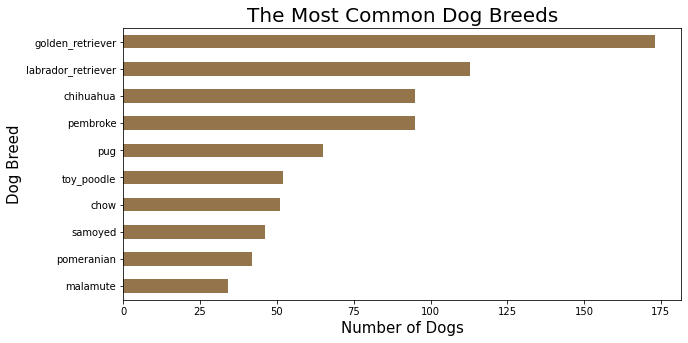

In [122]:
dog = master["dog_breed"].value_counts()[:10]
dog.sort_values(ascending=True).plot(kind="barh"  , color = '#94744B' ,figsize = (10,5));
plt.title('The Most Common Dog Breeds' ,fontsize = 20);
plt.ylabel("Dog Breed",fontsize = 15);
plt.xticks(rotation=0)
plt.xlabel("Number of Dogs",fontsize = 15);